In [1]:
# !nvidia-smi
# https://medium.com/analytics-vidhya/install-tensorflow-gpu-2-4-0-with-cuda-11-0-and-cudnn-8-using-anaconda-8c6472c9653f

# Pre-Processing and Training the Model
This notebook goes through the steps in turning the cleaned data into a representation that can be used to train a pre-trained BERT model for sentiment analysis.

__Columns__
- `target` sentiment of tweet (0=positive, 1=negative)
- `tweet` cleaned tweet text

The processes used in this notebook were inspired by the [this tutorial](https://www.tensorflow.org/tutorials/text/classify_text_with_bert) in the TensorFlow Docs.

_Note:_
_This notebook expects the zipped datasets to be in the ./resources sub-directory with the names train_twitter_data.zip, test_twitter_data, and validate_twitter_data (e.g., ./resources/train_twitter_data.zip). If the datasets do not exist open and run the `cleaning.ipynb` notebook to generate them._

In [2]:
import sys 
!{sys.executable} -m pip install tf-nightly --user
!{sys.executable} -m pip install tensorflow-text-nightly --user
!{sys.executable} -m pip install tf-models-nightly --user
!{sys.executable} -m pip install pydot

In [3]:
import os
import shutil

import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

C:\Users\ryand\anaconda3\envs\tf-nlp\lib\site-packages\tensorflow_addons\utils\ensure_tf_install.py:37: UserWarning: You are currently using a nightly version of TensorFlow (2.5.0-dev20210310). 
TensorFlow Addons offers no support for the nightly versions of TensorFlow. Some things might work, some other might not. 
If you encounter a bug, do not file an issue on GitHub.
  warnings.warn(


In [4]:
tf.config.set_visible_devices([], 'GPU')
tf.config.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Read Files
Read the files into memory and convert them to TensorFlow datasets to begin pre-processing.

In [5]:
RESOURCES_PATH = './resources/{}'
BATCH_SIZE=16

def twitter_data_to_dataset(filename):
    pd_df = pd.read_csv(RESOURCES_PATH.format(filename), encoding = 'ISO-8859-1', compression='zip')
    tweets =  tf.constant(pd_df['tweet'].to_numpy(dtype='U'), dtype=tf.string)
    targets = tf.constant(pd_df['target'].to_numpy(dtype='i4'), dtype=tf.int32)
    raw_ds = tf.data.Dataset.from_tensor_slices((tweets, targets))
    return raw_ds.batch(BATCH_SIZE, drop_remainder=False).cache().prefetch(buffer_size=tf.data.AUTOTUNE)

train_ds = twitter_data_to_dataset('train_twitter_data.zip')
test_ds = twitter_data_to_dataset('test_twitter_data.zip')
val_ds = twitter_data_to_dataset('validate_twitter_data.zip')

In [6]:
for text_batch, label_batch in train_ds.take(1):
    for i in range(3):
        print(f'Review: {text_batch.numpy()[i]}')
        print(f'Label : {label_batch.numpy()[i]}')

Review: b'i hate having a cold'
Label : 1
Review: b'oh that is weird'
Label : 1
Review: b'just flew back to china and was saddened to discover that blogspot and blogger was blogged can not blog now'
Label : 1


## Load BERT Resources

In [7]:
tfhub_handle_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
tfhub_handle_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

print(f'BERT model           : {tfhub_handle_encoder}')
print(f'Preprocess model     : {tfhub_handle_preprocess}')

BERT model           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Preprocess model     : https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


### Pre-Processor

In [8]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [9]:
text_test = ['the product was my favorite']
text_preprocessed = bert_preprocess_model(text_test)

print(f'Keys       : {list(text_preprocessed.keys())}')
print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}')

Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [ 101 1996 4031 2001 2026 5440  102    0    0    0    0    0]
Input Mask : [1 1 1 1 1 1 1 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]


### Model

In [10]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [11]:
bert_results = bert_model(text_preprocessed)

print(f'Loaded BERT: {tfhub_handle_encoder}')
print(f'Pooled Outputs Shape:{bert_results["pooled_output"].shape}')
print(f'Pooled Outputs Values:{bert_results["pooled_output"][0, :12]}')
print(f'Sequence Outputs Shape:{bert_results["sequence_output"].shape}')
print(f'Sequence Outputs Values:{bert_results["sequence_output"][0, :12]}')

Loaded BERT: https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Pooled Outputs Shape:(1, 512)
Pooled Outputs Values:[ 0.6691764   0.58543855 -0.0314561   0.48074463 -0.25392526  0.8787984
  0.9961011  -0.9899798   0.09613888 -0.8066808  -0.01391775 -0.99810755]
Sequence Outputs Shape:(1, 128, 512)
Sequence Outputs Values:[[-0.01279837  0.9729931   0.32275626 ... -0.76048213  1.4174023
  -0.57385325]
 [-0.1144598   0.30194023 -1.2570345  ... -0.32878464  0.74750984
   0.2168648 ]
 [-0.91389835  0.1244075   0.7862899  ...  0.5537697   1.3620057
  -0.32195392]
 ...
 [-0.15185931 -0.08935617  0.14648202 ...  0.1457319   0.95670724
   0.15815215]
 [-0.06271622 -0.01314841  0.16347808 ... -0.02113535  0.90248054
  -0.17281137]
 [ 0.01646246  0.21026973  0.17396608 ... -0.1056128   0.9892045
  -0.3466006 ]]


## Define Model
A fine-tuned model for tweet sentiment analysis will be constructed using the input layer, a pre-processing model, the uncased BERT model, one Dense layer, and a Dropout layer.


In [12]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dropout(0.1)(net)
    net = tf.keras.layers.Dense(1, activation=None, name='classifier')(net)
    return tf.keras.Model(text_input, net)

In [13]:
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.24863514]], shape=(1, 1), dtype=float32)


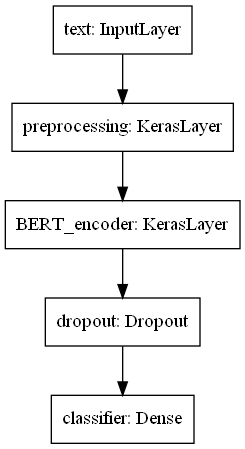

In [14]:
tf.keras.utils.plot_model(classifier_model, RESOURCES_PATH.format('model.png'))

## Train Model

### Loss Function
Tweet sentiment classification between positive and negative is actually a binary classification problem at its core. It outputs a singlue-unit layer in the form of a probability making binary crossentropy the function of choice to measure loss.

In [15]:
loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()

### Optimizer
Use the same optimizer BERT was trained with the Adam (Adaptive Moments) optimizer.

In [16]:
EPOCHS = 1
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * EPOCHS
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')

### Compile and Train
Now that `loss`, `metrics`, and our `optimizer` are defined we can compile our model and begin training.

In [17]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

In [18]:
print(f'Training model with {tfhub_handle_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=EPOCHS)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
55/80 [===================>..........] - ETA: 1:17 - loss: 0.4128 - binary_accuracy: 0.6442

ResourceExhaustedError:  OOM when allocating tensor with shape[16,8,128,128] and type float on /job:localhost/replica:0/task:0/device:CPU:0 by allocator cpu
	 [[{{node model/BERT_encoder/StatefulPartitionedCall/StatefulPartitionedCall/StatefulPartitionedCall/bert_encoder/StatefulPartitionedCall/transformer/layer_2/self_attention/einsum/Einsum}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.
 [Op:__inference_train_function_65232]

Function call stack:
train_function


### Evaluate

In [ ]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

In [ ]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

### Save Model

In [ ]:
dataset_name = 'twitter_sentiment'
saved_model_path = './resources/{}_bert'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path, include_optimizer=False)

### Reload Model and Test Locally

In [ ]:
reloaded_model = tf.saved_model.load(saved_model_path)

In [ ]:
def print_my_examples(inputs, results):
    result_for_printing = [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}' for i in range(len(inputs))]
    print(*result_for_printing, sep='\n')
    print()


examples = [
    'the product was my favorite',  # this is the same sentence tried earlier
    'the product was so great',
    'the product was meh',
    'the products was okish',
    'the product was terrible'
]

reloaded_results = tf.sigmoid(reloaded_model(tf.constant(examples)))
original_results = tf.sigmoid(classifier_model(tf.constant(examples)))

print('Results from the saved model:')
print_my_examples(examples, reloaded_results)

print('Results from the model in memory:')
print_my_examples(examples, original_results)

### Test with TF Serving

In [ ]:
serving_results = reloaded_model.signatures['serving_default'](tf.constant(examples))
serving_results = tf.sigmoid(serving_results['classifier'])

print_my_examples(examples, serving_results)